<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/COVID_TestingMetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=d251117074f9407d8e8c32b87807eff26941d70292fbc6a4635dd24ef0ef471e
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [4]:
import pandas as pd
import wget 
from PIL import Image

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error

from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load US State FIPS

In [5]:
state_fips_code = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/US_State_FIPSCodes.csv',low_memory=False)
state_fips_code.head()

,State,Postal Code,STFIPS
0,Alabama,AL,1
1,Alaska,AK,2
2,Arizona,AZ,4
3,Arkansas,AR,5
4,California,CA,6


# Load Maryland Inertia data

In [6]:
maryland_sd_inertia = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/Maryland_Inertia_Data/County_Oct13.csv',low_memory=False)
maryland_sd_inertia.head()

,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate
0,1001,Autauga County,1,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,1/1/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
1,1001,Autauga County,1,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,1/2/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
2,1001,Autauga County,1,15,15,3.18,42.2,1.0,40.3,0.62,2.57,0,55601,-0.4,1/3/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
3,1001,Autauga County,1,33,20,2.85,43.9,1.2,29.5,0.33,2.52,0,55601,-2.3,1/4/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
4,1001,Autauga County,1,40,22,2.56,42.8,1.2,30.9,0.23,2.33,0,55601,-9.7,1/5/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0


## Fix date column

In [7]:
def fixDate(x, appendTwenty):
  arr = x.split('/')
  m = arr[0]
  d = arr[1]
  y = arr[2]

  if int(m) < 10:
    m = '0'+str(m)
  if int(d) < 10:
    d = '0'+str(d)
  if appendTwenty == True:
    return '20'+y+'-'+m+'-'+d
  else:
      return y+'-'+m+'-'+d

## Data Preprocessing

In [8]:
maryland_sd_inertia['date'] = maryland_sd_inertia['date'].apply(lambda x: fixDate(x,False))
maryland_sd_inertia.reset_index(drop=True)

,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate
0,1001,Autauga County,1,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,2020-01-01,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
1,1001,Autauga County,1,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,2020-01-02,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
2,1001,Autauga County,1,15,15,3.18,42.2,1.0,40.3,0.62,2.57,0,55601,-0.4,2020-01-03,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
3,1001,Autauga County,1,33,20,2.85,43.9,1.2,29.5,0.33,2.52,0,55601,-2.3,2020-01-04,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
4,1001,Autauga County,1,40,22,2.56,42.8,1.2,30.9,0.23,2.33,0,55601,-9.7,2020-01-05,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901749,56045,Weston County,56,40,20,3.00,27.4,10.3,172.4,0.04,2.96,3,6967,-16.3,2020-10-09,8.34,30,52867,0.5,1.5,53.07,3,1,153,3.76,0.50,0.017,0.3828,5.50,0,38.319241,6.6,191.28,1.32,3,29,9.69,0,1.2,9.3,18.5,1.51,0.96
901750,56045,Weston County,56,37,22,3.37,26.1,10.3,90.4,0.11,3.26,4,6967,-7.8,2020-10-10,8.34,30,52867,0.5,1.5,53.07,3,1,153,3.76,0.50,0.017,0.3828,5.65,0,38.321286,6.7,191.49,1.33,3,29,9.69,0,1.2,9.3,18.5,1.51,0.96
901751,56045,Weston County,56,42,26,2.70,24.5,13.1,71.9,0.06,2.64,0,6967,-25.3,2020-10-11,8.34,30,52867,0.5,1.5,53.07,3,1,153,3.76,0.50,0.017,0.3349,5.81,0,38.323483,6.9,191.76,1.33,3,25,9.69,0,1.2,9.3,18.5,1.51,0.96
901752,56045,Weston County,56,26,19,3.05,25.3,9.9,102.7,0.04,3.00,0,6967,-15.2,2020-10-12,8.34,30,52867,0.5,1.5,53.07,3,1,153,3.76,0.50,0.017,0.1914,6.08,0,38.324928,7.0,192.09,1.33,3,24,9.69,0,1.2,9.3,18.5,1.51,0.96


## Merge State name with inertia data

In [9]:
maryland_sd_inertia = pd.merge(state_fips_code,maryland_sd_inertia,how='inner',left_on=['STFIPS'],right_on=['STFIPS'])
print(maryland_sd_inertia.shape)

maryland_sd_inertia.head(2)

(901467, 45)


,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate
0,Alabama,AL,1,1001,Autauga County,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,2020-01-01,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
1,Alabama,AL,1,1001,Autauga County,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,2020-01-02,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0


## Filter data for Six states

In [11]:
state_list = ['California', 'New York', 'Texas', 'Iowa', 'Wisconsin', 'Colorado']

maryland_sd_inertia_6states = maryland_sd_inertia[maryland_sd_inertia['State'].isin(state_list)]
maryland_sd_inertia_6states.head(3)

,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate
53382,California,CA,6,6001,Alameda County,50,32,2.41,26.1,0.4,38.0,0.20,2.21,0,1666753,-21.7,2020-01-01,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0
53383,California,CA,6,6001,Alameda County,24,22,3.17,27.9,0.4,38.5,0.50,2.66,0,1666753,-5.8,2020-01-02,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0
53384,California,CA,6,6001,Alameda County,21,21,3.28,27.2,0.4,41.0,0.51,2.78,0,1666753,-1.5,2020-01-03,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0


## Clustering COVID Testing & Contact tracing metrics

In [18]:
X4_cols = ['# hot spots/1000 people',
       '# contact tracing workers/1000 people',
        'Testing capacity',
       'Tests done/1000 people', 
       'Imported COVID cases', 'COVID exposure/1000 people', 
       'New cases/1000 people']

In [13]:
maryland_sd_inertia_6states_filtered = maryland_sd_inertia_6states.dropna()

In [19]:
training_inputs = maryland_sd_inertia_6states_filtered[X4_cols].values
#training_outputs_labels = [c for row in maryland_sd_inertia_6states[Y_col].values for c in row]
print(training_inputs.shape)

(139769, 7)


# K-means Cosine Similiarity Distancing 

In [20]:
X = training_inputs
print(X.shape)

(139769, 7)


## Determine Silhoutte score

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


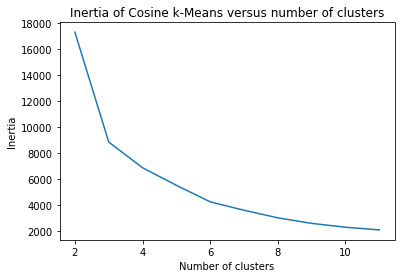

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score


normalized_vectors = preprocessing.normalize(X)
scores = [KMeans(n_clusters=i+2).fit(normalized_vectors).inertia_  
          for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of Cosine k-Means versus number of clusters")
plt.savefig("intertia_cosine_kmeans.jpg", dpi=300)

# First Cluster

In [24]:
normalized_vectors = preprocessing.normalize(X)
normalized_kmeans = KMeans(n_clusters=3).fit(normalized_vectors)

print('Cosine kmeans:{}'.format(silhouette_score(normalized_vectors,
                                          normalized_kmeans.labels_,
                                          metric='cosine')))


Cosine kmeans:0.7715744581312984


# Helper methods

In [25]:

# Data handling
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

%matplotlib inline 


def plot_corr(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
def plot_tsne(tnse_data, kmeans_labels):
    df_tsne = pd.DataFrame(tsne_data).rename({0: 'x', 1: 'y'}, axis=1)
    df_tsne['z'] = kmeans_labels
    sns.scatterplot(x=df_tsne.x, y=df_tsne.y, hue=df_tsne.z, palette="Set2")
    plt.show()
    
def prepare_pca(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

def prepare_tsne(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

def plot_3d(df, name='labels'):
    iris = px.data.iris()
    fig = px.scatter_3d(df, x='x', y='y', z='z',
                  color=name, opacity=0.5)
    

    fig.update_traces(marker=dict(size=3))
    fig.show()
    
def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)

    N=360
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tsne_3d_df['x'], tsne_3d_df['y'], tsne_3d_df['z'], c=tsne_3d_df[label_column],
               s=6, depthshade=True, cmap='Paired')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    ani.save('{}.gif'.format(name), writer='imagemagick')
    plt.show()

In [40]:
def fractal_clustering(df, cluster_label = 0,n_clusters=5):
    df_filtered = df[df['cluster'] == cluster_label]
    training_inputs = df_filtered[X_cols].values

    X = training_inputs
    normalized_vectors = preprocessing.normalize(training_inputs)
    normalized_kmeans = KMeans(n_clusters=n_clusters).fit(normalized_vectors)
    print('Cosine kmeans:{}'.format(silhouette_score(normalized_vectors,
                                          normalized_kmeans.labels_,
                                          metric='cosine')))
    
    pca_df = prepare_pca(2, X, normalized_kmeans.labels_)
    sns.scatterplot(x=pca_df.x, y=pca_df.y, hue=pca_df.labels, 
                palette="Set2")
    
    df_filtered['cluster'] = pca_df.labels.to_list()
  
    return df_filtered

In [46]:
def rename_cluster_label(x, prefix = 'cluster_'):
  return prefix+str(x)

# First cluster - plot

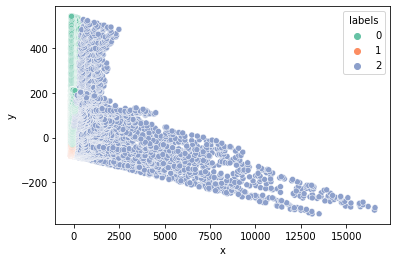

In [26]:
pca_df = prepare_pca(2, X, normalized_kmeans.labels_)
sns.scatterplot(x=pca_df.x, y=pca_df.y, hue=pca_df.labels, 
                palette="Set2")

In [27]:
for label in pca_df.labels.unique():
  print("label", label, "  shape",pca_df[pca_df.labels == label].shape)

label 1   shape (74976, 3)
label 0   shape (39273, 3)
label 2   shape (25520, 3)


In [28]:
maryland_sd_inertia_6states_filtered['cluster'] = pca_df.labels.to_list()
maryland_sd_inertia_6states_filtered.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,cluster
226156,Iowa,IA,19,19001,Adair County,51,31,2.39,59.9,15.9,44.7,0.21,2.18,0,7063,-26.9,2020-01-01,0.34,31,51859,0.4,1.9,49.35,12,5,169,3.69,0.26,0.011,0.0,0.0,0,30.0,0.0,0.0,0.0,0,0,0.0,0,1.6,2.8,4.8,0.2,0.0,1
226157,Iowa,IA,19,19001,Adair County,15,18,3.68,55.5,12.0,72.5,0.37,3.31,0,7063,11.0,2020-01-02,0.34,31,51859,0.4,1.9,49.35,12,5,169,3.69,0.26,0.011,0.0,0.0,0,30.0,0.0,0.0,0.0,0,0,0.0,0,1.6,2.8,4.8,0.2,0.0,1


# Fractal Clustering :: Cluster 0

In [38]:
cluster0 = maryland_sd_inertia_6states_filtered[maryland_sd_inertia_6states_filtered['cluster'] == 0]
print(cluster0.shape)

(39273, 46)


In [36]:
X_cols = X4_cols

Cosine kmeans:0.569085650534261
(39273, 46)
label 0   shape (13109, 46)
label 1   shape (12403, 46)
label 2   shape (13761, 46)


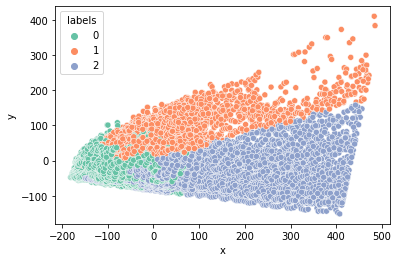

In [42]:
df_cluster0 = fractal_clustering(cluster0, cluster_label=0,n_clusters=3)
print(df_cluster0.shape)

for label in df_cluster0.cluster.unique():
  print("label", label, "  shape",df_cluster0[df_cluster0.cluster == label].shape)

## Fractal clustering :: Cluster_0_0

Cosine kmeans:0.567082917376789
(13109, 46)
label 1   shape (3944, 46)
label 2   shape (3767, 46)
label 0   shape (5398, 46)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



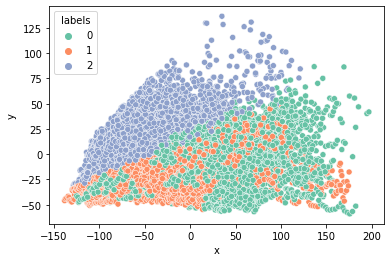

In [43]:
df_cluster0_0 = fractal_clustering(df_cluster0, cluster_label=0,n_clusters=3)
print(df_cluster0_0.shape)

for label in df_cluster0_0.cluster.unique():
  print("label", label, "  shape",df_cluster0_0[df_cluster0_0.cluster == label].shape)

### Fractal clustering :: Cluster 0_0_0

Cosine kmeans:0.530857562631463


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(5398, 46)
label 0   shape (1679, 46)
label 2   shape (1695, 46)
label 1   shape (2024, 46)


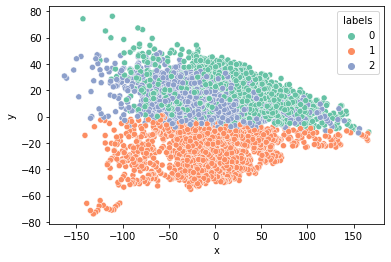

In [44]:
df_cluster0_0_0 = fractal_clustering(df_cluster0_0, cluster_label=0,n_clusters=3)
print(df_cluster0_0_0.shape)

for label in df_cluster0_0_0.cluster.unique():
  print("label", label, "  shape",df_cluster0_0_0[df_cluster0_0_0.cluster == label].shape)

In [47]:
df_cluster0_0_0['cluster_label'] = df_cluster0_0_0['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_0_'))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
final_data = df_cluster0_0_0.copy()

### Fractal clustering :: Cluster 0_0_1

Cosine kmeans:0.5331934878909605
(3944, 46)
label 2   shape (1293, 46)
label 0   shape (1197, 46)
label 1   shape (1454, 46)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



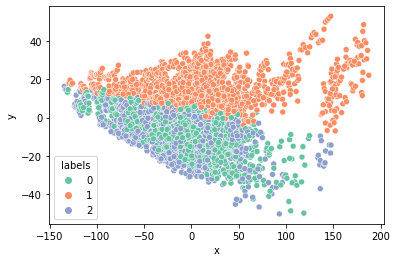

In [49]:
df_cluster0_0_1 = fractal_clustering(df_cluster0_0, cluster_label=1,n_clusters=3)
print(df_cluster0_0_1.shape)

for label in df_cluster0_0_1.cluster.unique():
  print("label", label, "  shape",df_cluster0_0_1[df_cluster0_0_1.cluster == label].shape)

In [51]:
df_cluster0_0_1['cluster_label'] = df_cluster0_0_1['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_1_'))
df_cluster0_0_1.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(3944, 47)

In [52]:
final_data.shape

(5398, 47)

In [53]:
final_data = pd.concat([final_data, df_cluster0_0_1])
final_data.shape

(9342, 47)

### Fractal clustering :: Cluster 0_0_2

Cosine kmeans:0.6018678027067041
(3767, 46)
label 1   shape (1196, 46)
label 0   shape (1449, 46)
label 2   shape (1122, 46)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



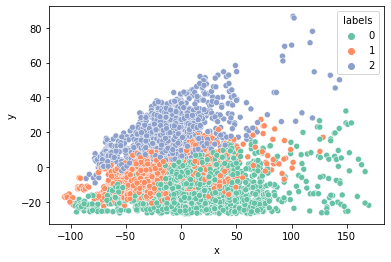

In [54]:
df_cluster0_0_2 = fractal_clustering(df_cluster0_0, cluster_label=2,n_clusters=3)
print(df_cluster0_0_2.shape)

for label in df_cluster0_0_2.cluster.unique():
  print("label", label, "  shape",df_cluster0_0_2[df_cluster0_0_2.cluster == label].shape)

In [55]:
df_cluster0_0_2['cluster_label'] = df_cluster0_0_2['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_2_'))
df_cluster0_0_2.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(3767, 47)

In [56]:
print(final_data.shape)
final_data = pd.concat([final_data, df_cluster0_0_2])
final_data.shape

(9342, 47)


(13109, 47)

In [58]:
df_cluster0_0.head(2) 

,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,cluster
226332,Iowa,IA,19,19001,Adair County,19,22,4.13,58.9,10.6,83.9,0.36,3.77,2,7063,26.4,2020-06-25,0.34,31,51859,0.4,1.9,49.35,12,5,169,3.69,0.26,0.011,0.0944,3.03,7,31.325065,9.8,87.78,5.13,29,55,7.57,0,2.6,7.2,32.1,0.59,2.91,1
226333,Iowa,IA,19,19001,Adair County,15,19,3.93,64.0,13.8,76.2,0.41,3.52,0,7063,18.1,2020-06-26,0.34,31,51859,0.4,1.9,49.35,12,5,169,3.69,0.26,0.011,0.0944,2.94,0,31.328351,9.8,89.87,5.13,28,54,7.63,0,2.6,7.2,32.1,0.59,2.92,1


## Fractal clustering :: Cluster_0_1

Cosine kmeans:0.5536085057913367
(12403, 46)
label 1   shape (3270, 46)
label 2   shape (4787, 46)
label 0   shape (4346, 46)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



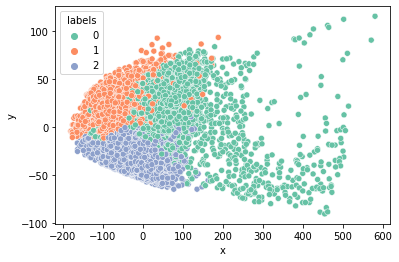

In [59]:
df_cluster0_1 = fractal_clustering(df_cluster0, cluster_label=1,n_clusters=3)
print(df_cluster0_1.shape)

for label in df_cluster0_1.cluster.unique():
  print("label", label, "  shape",df_cluster0_1[df_cluster0_1.cluster == label].shape)

#### Fractal Clustering :: Cluster_0_1_0

Cosine kmeans:0.5223570052310706
(4346, 46)
label 0   shape (1715, 46)
label 2   shape (1772, 46)
label 1   shape (859, 46)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



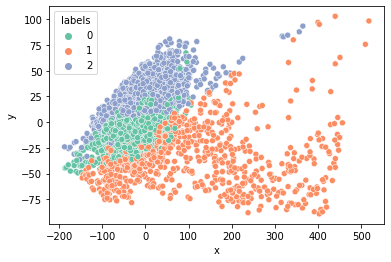

In [60]:
df_cluster0_1_0 = fractal_clustering(df_cluster0_1, cluster_label=0,n_clusters=3)
print(df_cluster0_1_0.shape)

for label in df_cluster0_1_0.cluster.unique():
  print("label", label, "  shape",df_cluster0_1_0[df_cluster0_1_0.cluster == label].shape)

In [61]:
df_cluster0_1_0['cluster_label'] = df_cluster0_1_0['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_1_0_'))
df_cluster0_1_0.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(4346, 47)

In [62]:
print(final_data.shape)
final_data = pd.concat([final_data, df_cluster0_1_0])
print(final_data.shape)


(13109, 47)
(17455, 47)


#### Fractal Clustering :: Cluster_0_1_1

#### Fractal Clustering :: Cluster_0_1_2

## Fractal clustering :: Cluster_0_2

# Fractal Clustering :: Cluster 1

In [31]:
df_cluster1 = maryland_sd_inertia_6states_filtered[maryland_sd_inertia_6states_filtered['cluster'] == 1]
print(df_cluster1.shape)

(74976, 46)


# Fractal Clustering :: Cluster 2

In [32]:
df_cluster2 = maryland_sd_inertia_6states_filtered[maryland_sd_inertia_6states_filtered['cluster'] == 2]
print(df_cluster2.shape)

(25520, 46)
